# Gamma Spectroscopy

In [93]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from adjust_sample import factor, df_correction
# from scipy.signal import lfilter
df_correction

,Unknown,Cs137,Na22,Co57,Co60,Cd109,Ba133,Eu152,Zn65,Mn54
half_life / days,86400.0,948602880.0,81993600.0,23478336.0,166194720.0,39864960.0,334281600.0,426366720.0,21075552.0,26956800.0
produce_date,2019-03-01,2022-11-01,2022-11-03,2022-11-03,2023-01-18,2022-12-16,2023-01-18,2022-09-07,2022-12-01,2019-03-01
t_exp / s,202.07,164.03,108.6,115.54,152.04,143.15,77.2,112.9,83.58,86.05
corr_factor,1.0,1.131907,0.69769,0.056887,0.79703,0.175973,2.029917,1.494032,0.049144,2.348286


## Sort out Background Noise

In [8]:
# specify file location
folder_name = ["eu152_csv", "na22_csv"]
file_name = ["Unknown", "bg"]
folder_select = folder_name[1]

# bg_noise to hold the counts, energy
bg_noise = []
t_list = []

# Search for "Elapsed Live Time" for background noise and Unknown
for i in range(len(file_name)):

    file_select = file_name[i]

    measurement_table = []
    with open(f"{folder_select}/{file_name[i]}.csv") as csvfile:
        read_data = csv.reader(csvfile, delimiter=',')

        for row in read_data:
            try:
                check = row[0]
            except:
                check = None
            if check == None or check != "Channel Data:":
                measurement_table.append(row)
            else:
                break
            
    condition = True
    while condition:
        try:
            measurement_table.remove([])
        except ValueError:
            condition=False

    df1 = pd.DataFrame(measurement_table)
    df2 = df1.T.iloc[:, 5:19]
    df2.columns = df2.iloc[0, :]
    measure_stat_df = df2.iloc[1:, :]

    t_list.append(float(measure_stat_df.loc[1, "Elapsed Live Time:"]))


# Store counts of background noise in bg_noise
with open(f"{folder_select}/{file_name[1]}.csv") as csvfile:
    read_data = csv.reader(csvfile, delimiter=',')
    test = 0
    for row in read_data:
        if test == 1:
            bg_noise.append(int(row[2]))
        elif len(row) >=1 and row[0] == "Channel":
            test = 1
        else:
            pass

bg_noise = np.array(bg_noise) * t_list[0] / t_list[1]




## Sort out Counts for each Isotope

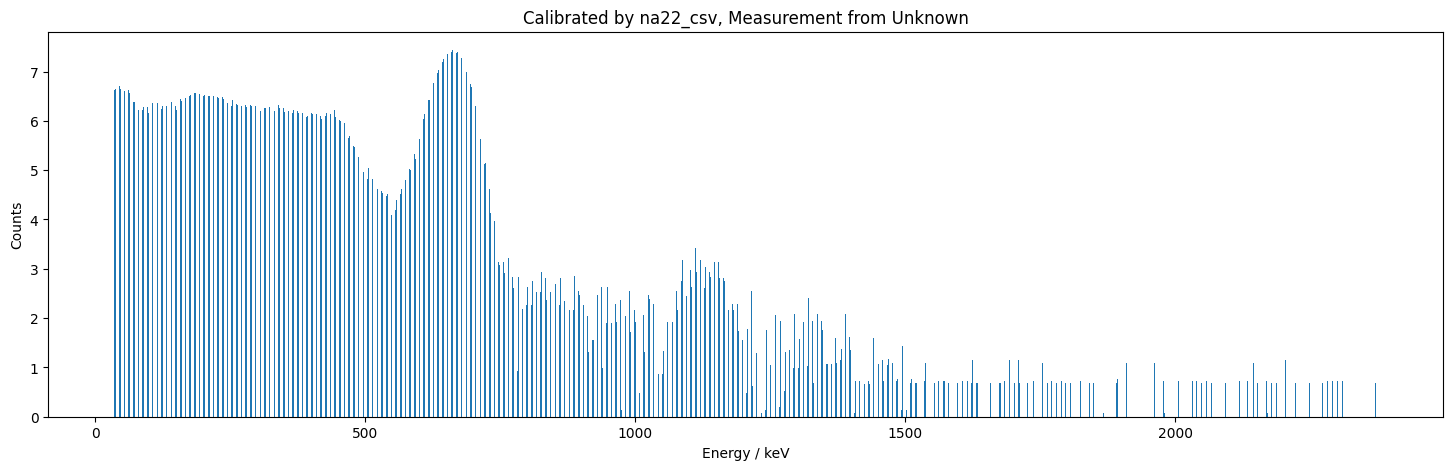

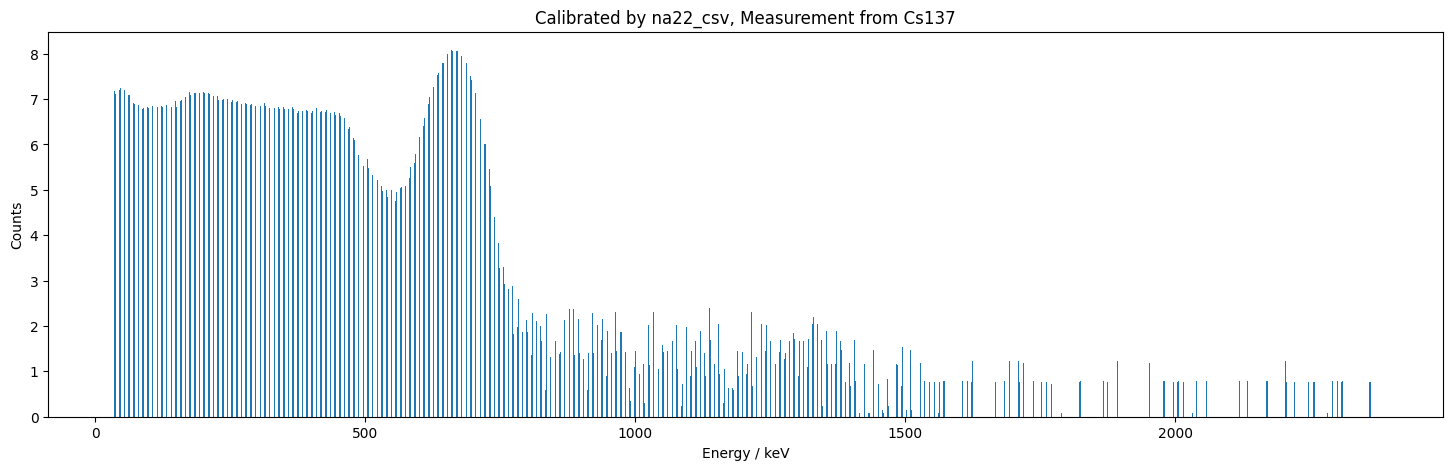

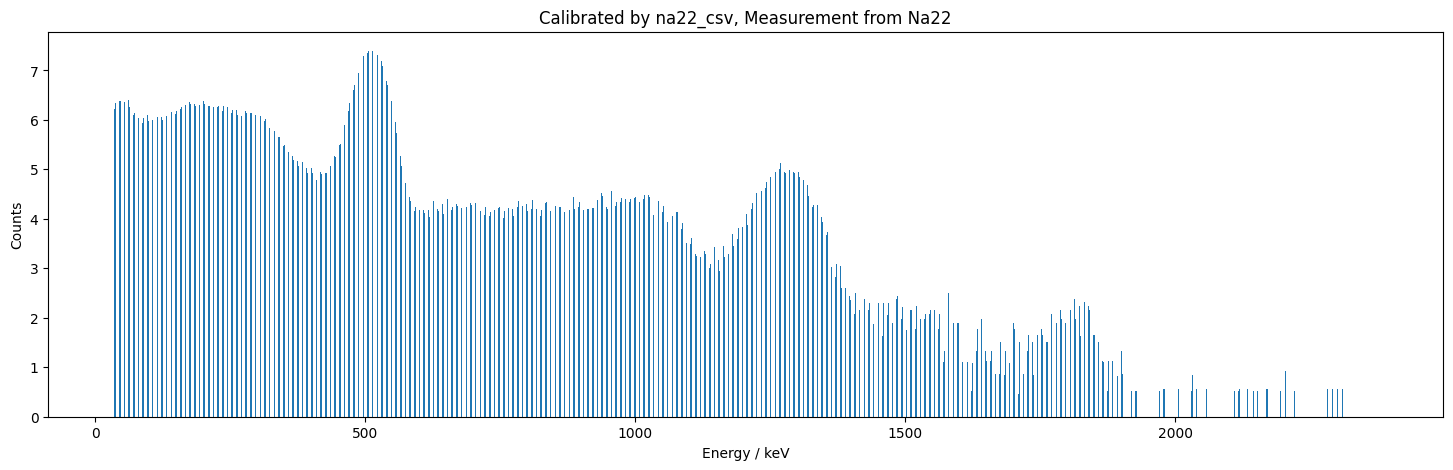

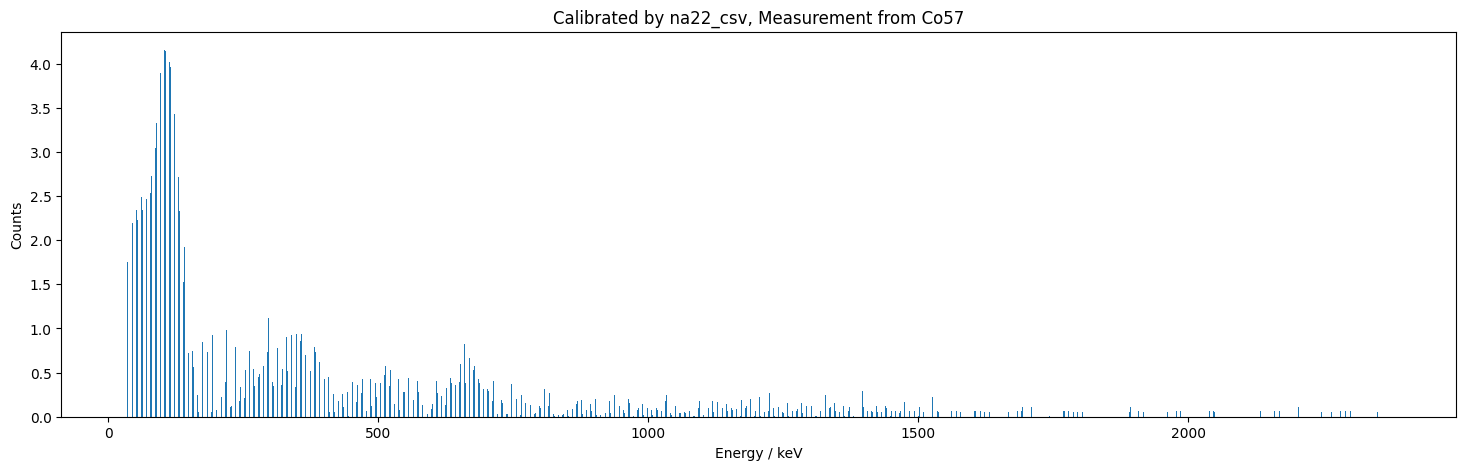

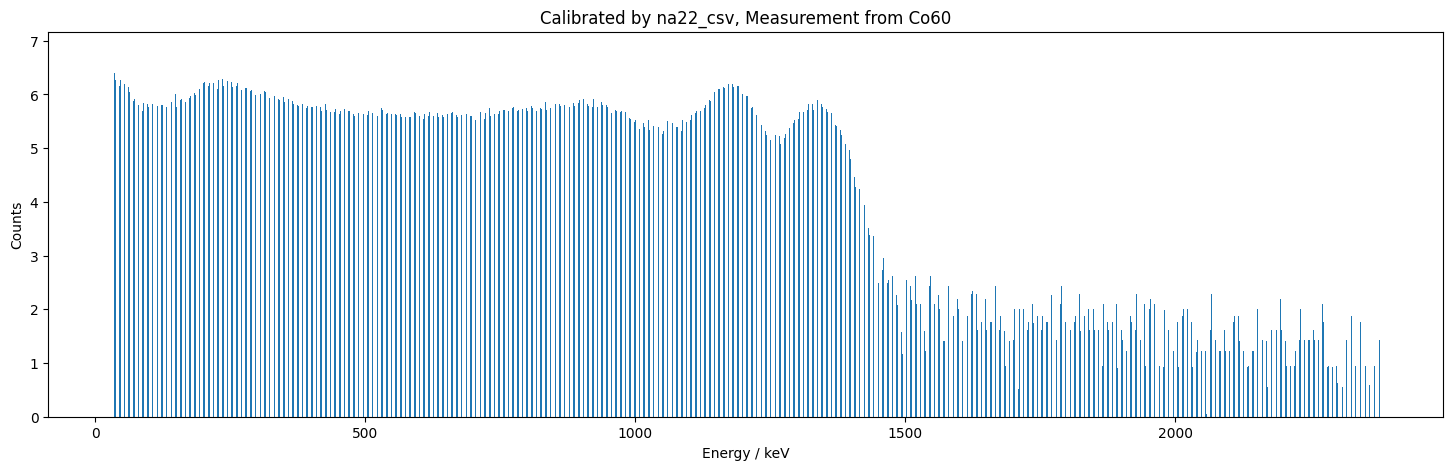

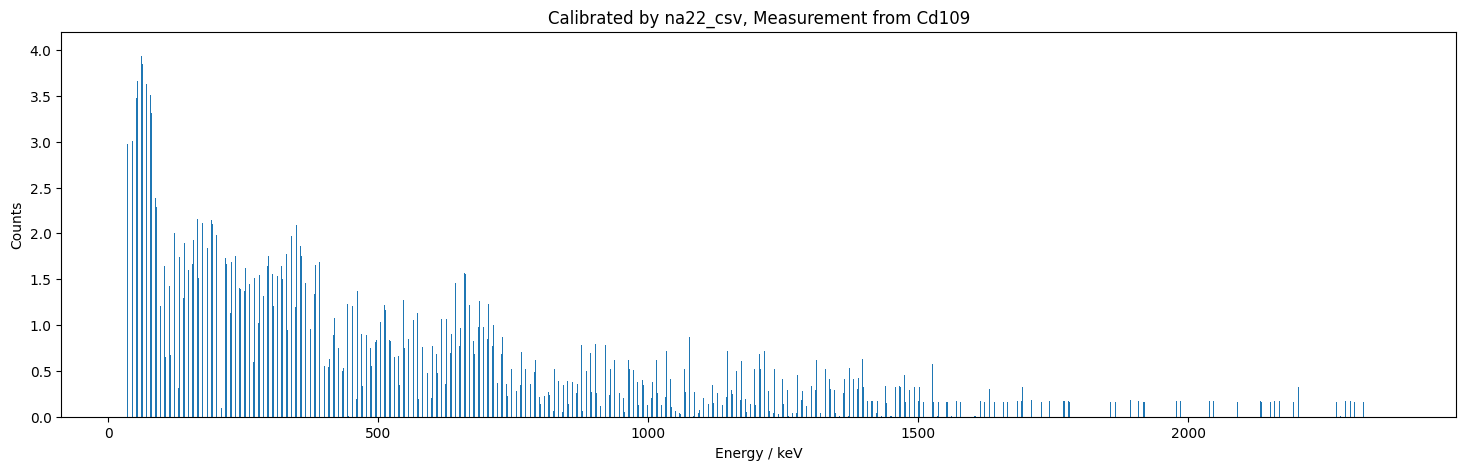

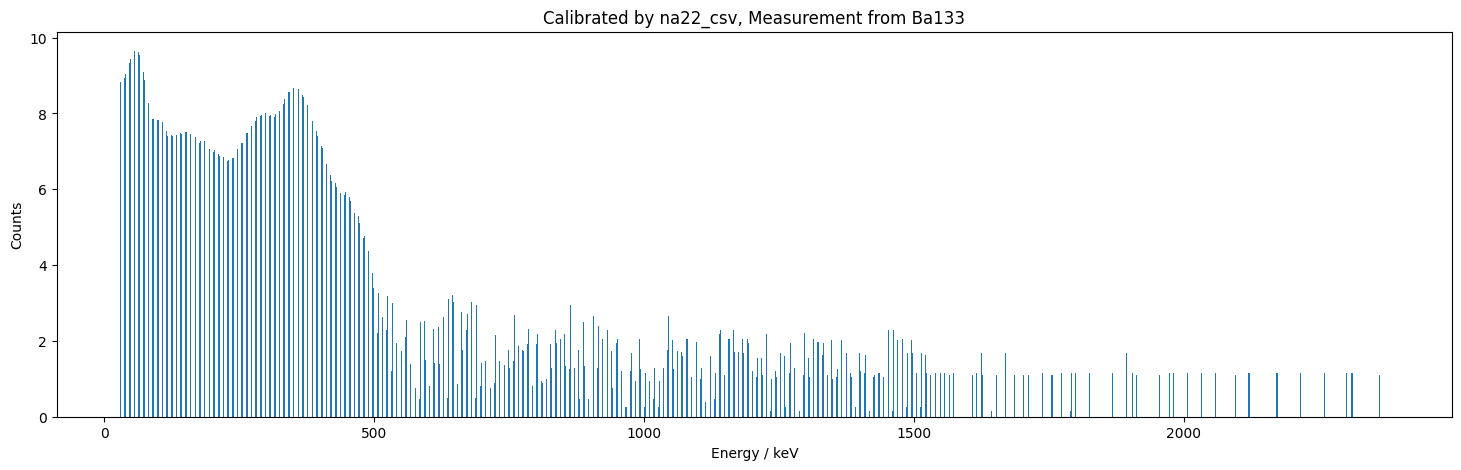

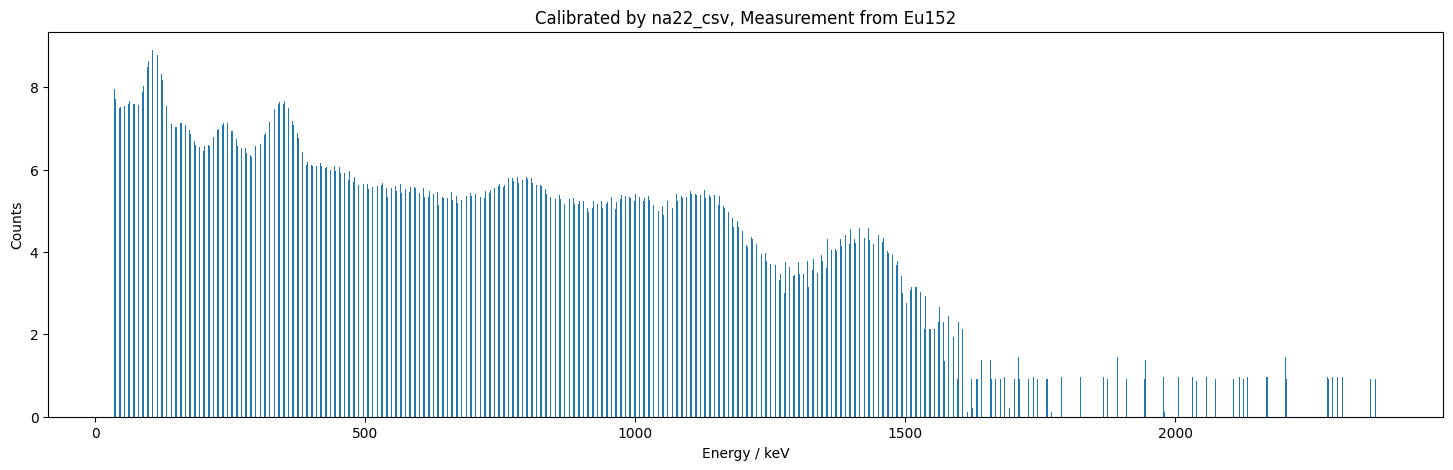

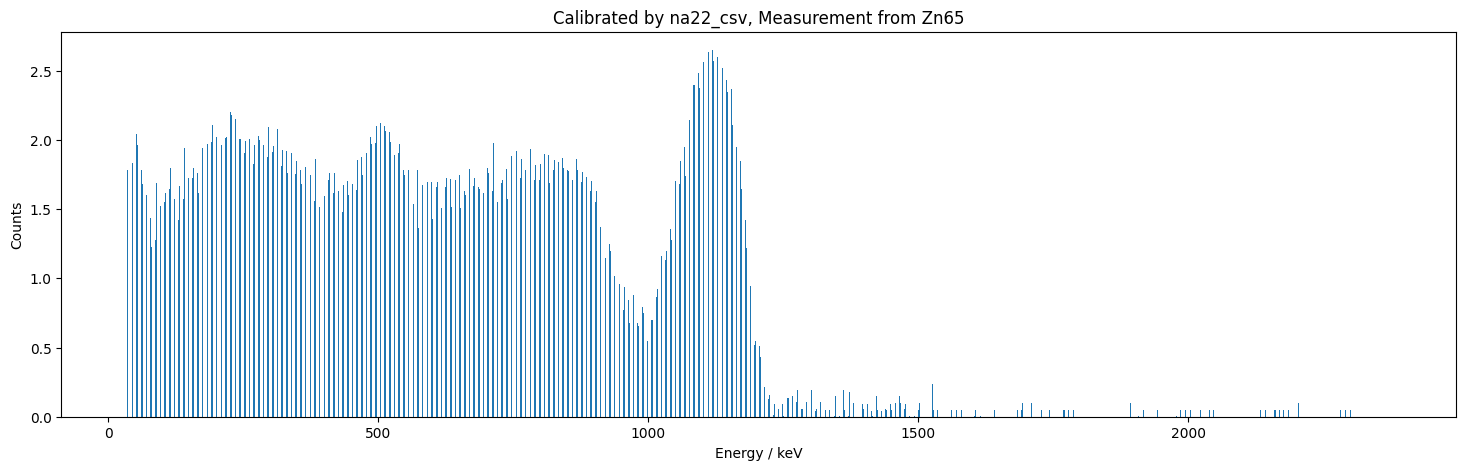

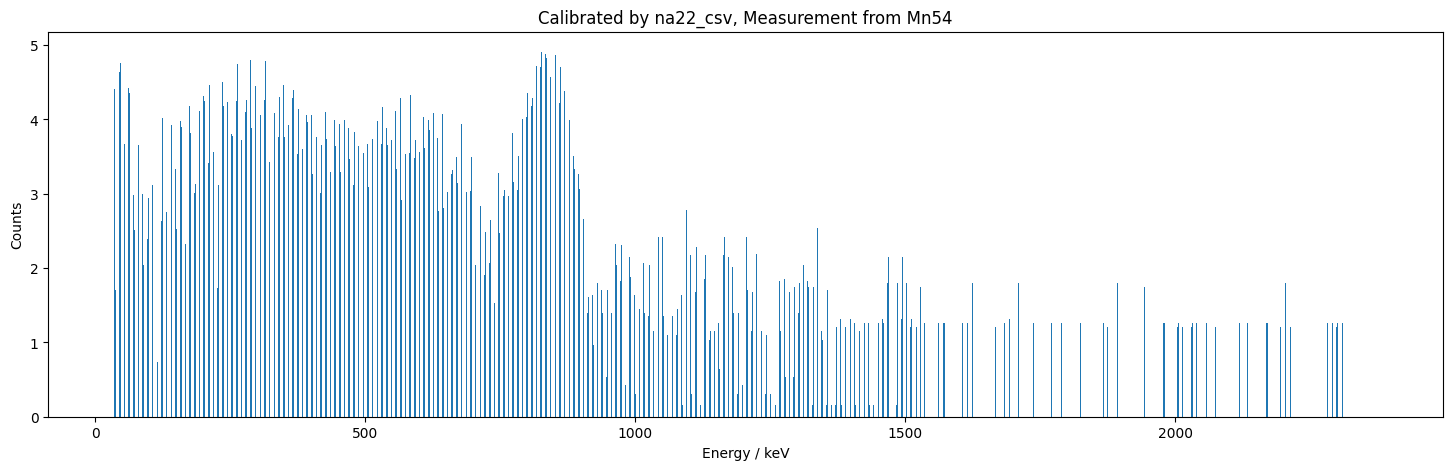

In [88]:
folder_name = ["eu152_csv", "na22_csv"]
file_name = ["Unknown", "Cs137", 
            "Na22", "Co57",
            "Co60", "Cd109", 
            "Ba133", "Eu152",
            "Zn65", "Mn54"]

channels = []
energys = []
countss = []

for i in range(len(file_name)):
    channel = []
    energy = []
    counts = []
    
    folder_select = folder_name[1]
    file_select = file_name[i]

    with open(f"{folder_select}/{file_select}.csv") as csvfile:
        read_data = csv.reader(csvfile, delimiter=',')

        test = 0
        for row in read_data:
            if test == 1:
                channel.append(int(row[0]))
                energy.append(float(row[1]))
                counts.append(int(row[2]))
            elif len(row) >=1 and row[0] == "Channel":
                test = 1
            else:
                pass



    energy = np.array(energy)
    counts = abs(np.array(counts) - bg_noise) # subtract background noise
    energy = energy[[i>=30 for i in energy]] # pick out energy > 30 keV

    # n = 5
    # b = [1.0 / n] * n
    # a = 1
    # counts = lfilter(b, a, counts)


    # counts is first adjust to the right dimension as the x-axis, 
    # then multiply with the time correction factor to align everything with the unknown
    # lastly take the log balance peaks' size
    # counts = np.log(factor[i] * counts[(len(counts) - len(energy)):] + 1)
    counts = factor[i] * counts[(len(counts) - len(energy)):]

    countss.append(counts)
    
    fig, ax = plt.subplots(figsize=(18, 5))
    ax.bar(energy, np.log(counts+1))
    ax.set_title(f"Calibrated by {folder_select}, Measurement from {file_select}")
    ax.set_xlabel("Energy / keV")
    ax.set_ylabel("Counts")

## Least Square Fitting

In [89]:
def eval_cost(y1, y2, y3, a):
    cost_array = abs((a * y1 + (1 - a) * y2) ** 2 - (y3) ** 2)
    return cost_array.sum()


ele_min_cost = []
proportion = []
ele_name = []
cs_counts = countss[1]
unknown_counts = countss[0]
cs_half = df_correction.iloc[0, 1]
x_list = np.linspace(0, 1, 100)
def altogether():
    for ele in range(len(file_name)):
        if file_name[ele] != "Unknown" and file_name[ele] != "Cs137":
            ele_name.append(file_name[ele])
            counts = countss[ele]
            cost_list = []
            for a in range(len(x_list)):
                cost_sum = eval_cost(cs_counts, counts, unknown_counts, x_list[a])
                cost_list.append(cost_sum)
            
            ele_min_cost.append(np.array(cost_list).min())
            proportion.append(x_list[np.argmin(np.array(cost_list))])

        else:
            pass


altogether()

In [90]:
df_fit = pd.DataFrame(data=[ele_name, np.round(ele_min_cost), proportion]).T
df_fit.columns = ["ele_name", "ele_min_cost", "proportion"]
df_fit.sort_values(by="ele_min_cost", inplace=True, ignore_index=True)

In [91]:
elename = df_fit["ele_name"]
cost = df_fit["ele_min_cost"]
a = df_fit["proportion"]

display(df_fit)

print("Best case Scenario: \n"
      f"The element present are Cs137 with proportion {round(a[0], 3)} \n"
      f"with element {elename[0]} with proportion {round(1-a[0], 3)} \n"
      f"With the cost of {cost[0]}")


# fig, ax = plt.subplots(figsize=(18, 5))
# ax.bar(energy, (tot_pred_best))
# ax.set_title(f"tot_pred Cs137 and {ele_name[min_index]}")
# ax.set_xlabel("Energy / keV")
# ax.set_ylabel("Counts")

,ele_name,ele_min_cost,proportion
0,Mn54,13748806.0,0.525253
1,Cd109,14461463.0,0.535354
2,Co57,14517548.0,0.535354
3,Zn65,14722954.0,0.535354
4,Co60,43105806.0,0.424242
5,Na22,59488250.0,0.484848
6,Eu152,275294236.0,0.818182
7,Ba133,295587862.0,1.0


Best case Scenario: 
The element present are Cs137 with proportion 0.525 
with element Mn54 with proportion 0.475 
With the cost of 13748806.0


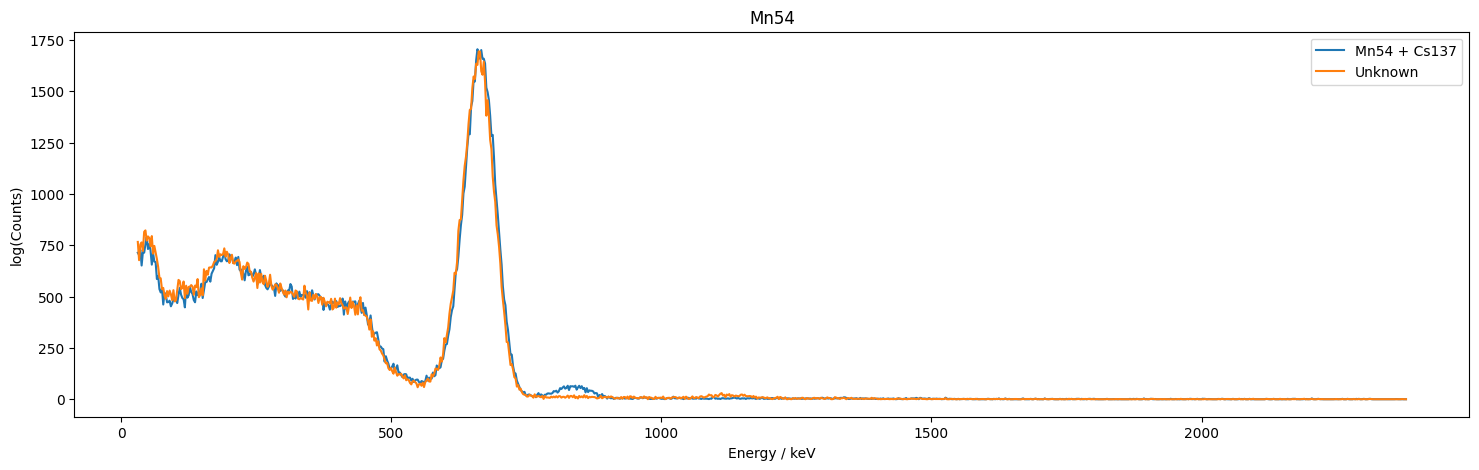

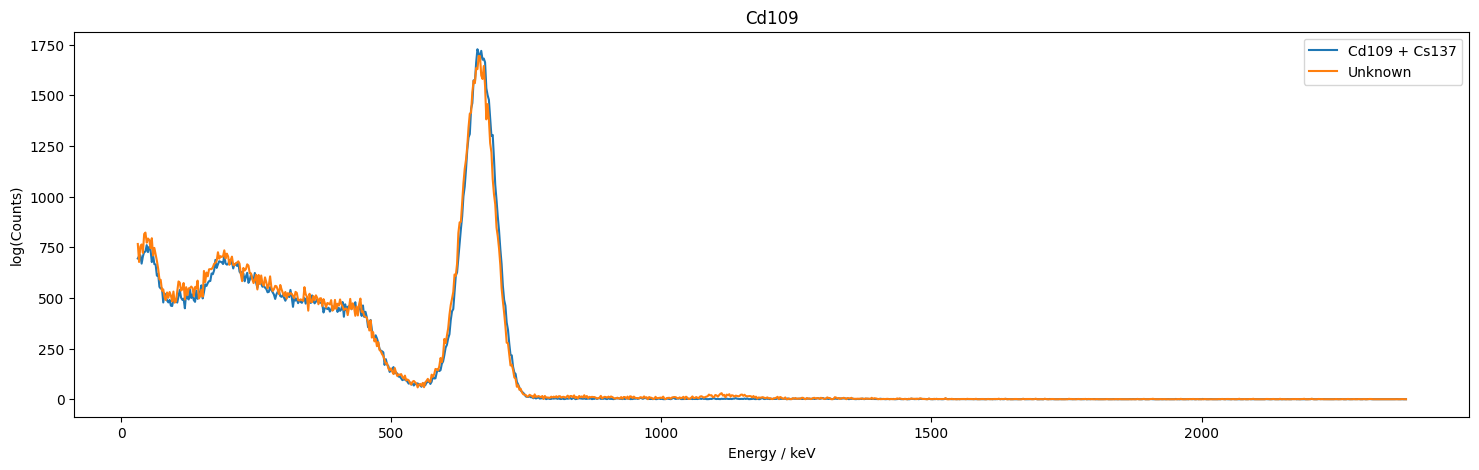

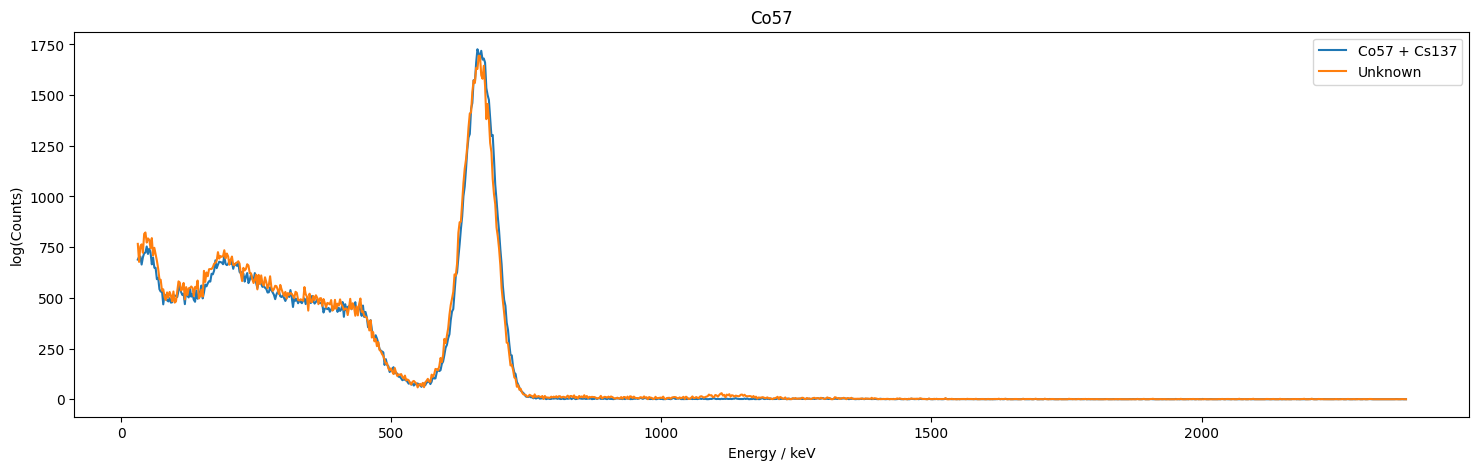

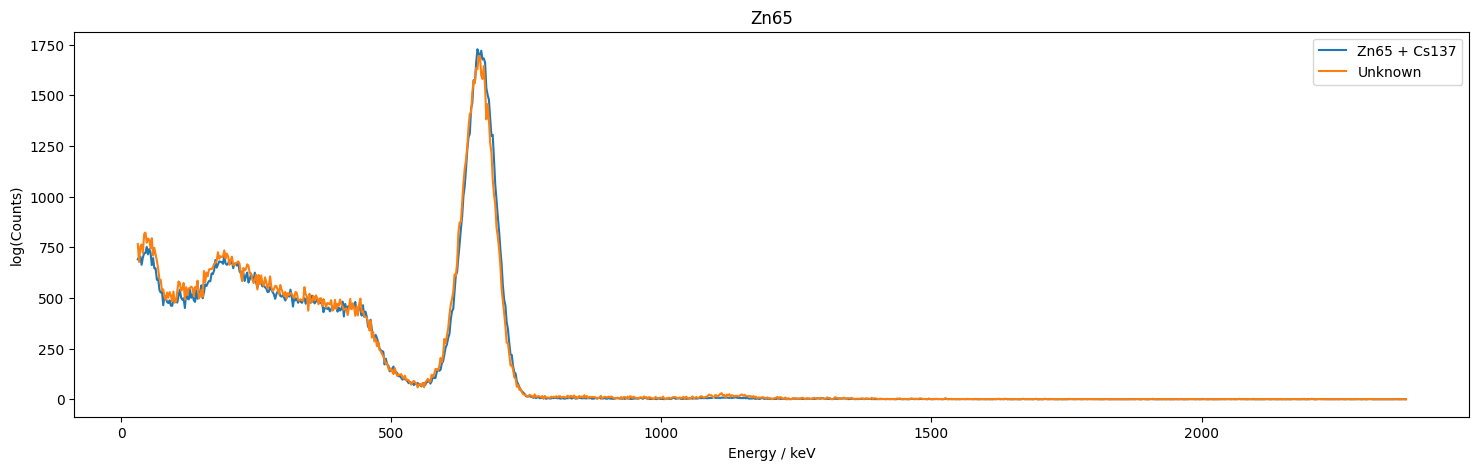

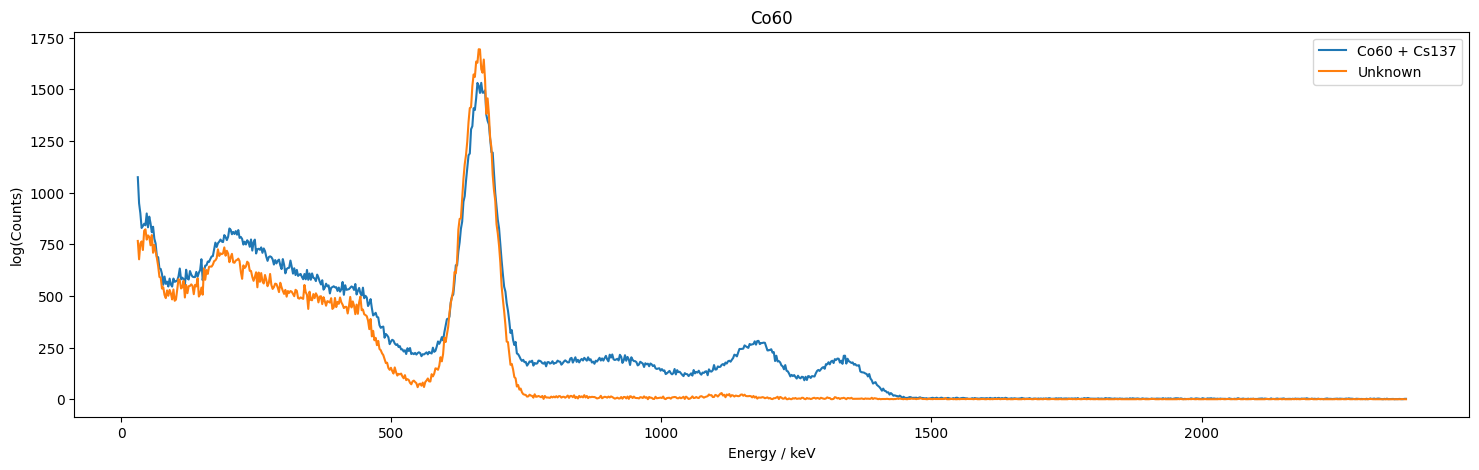

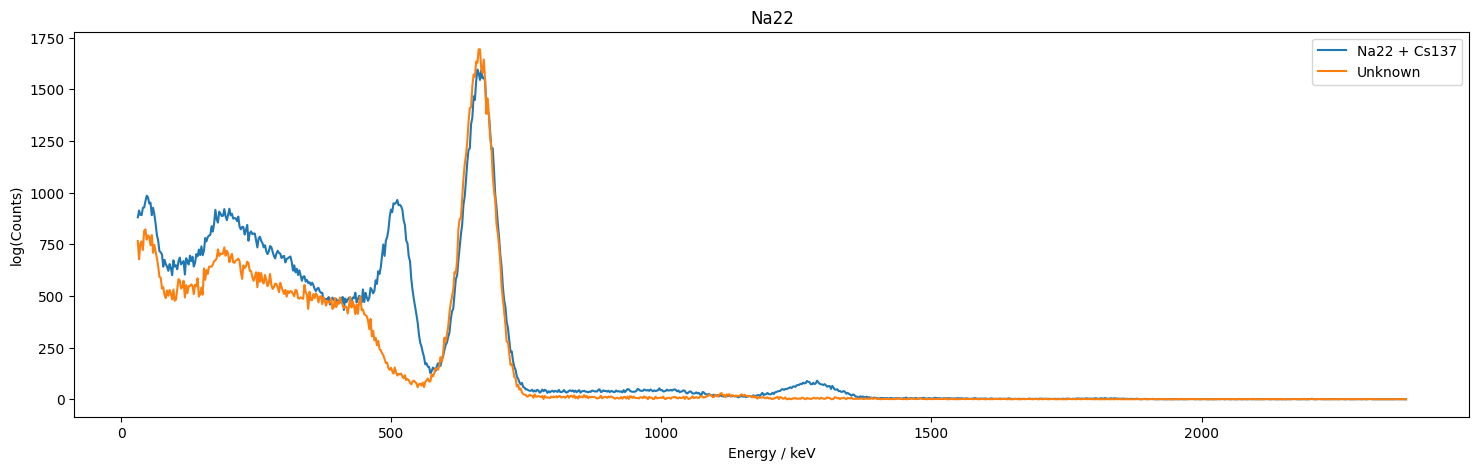

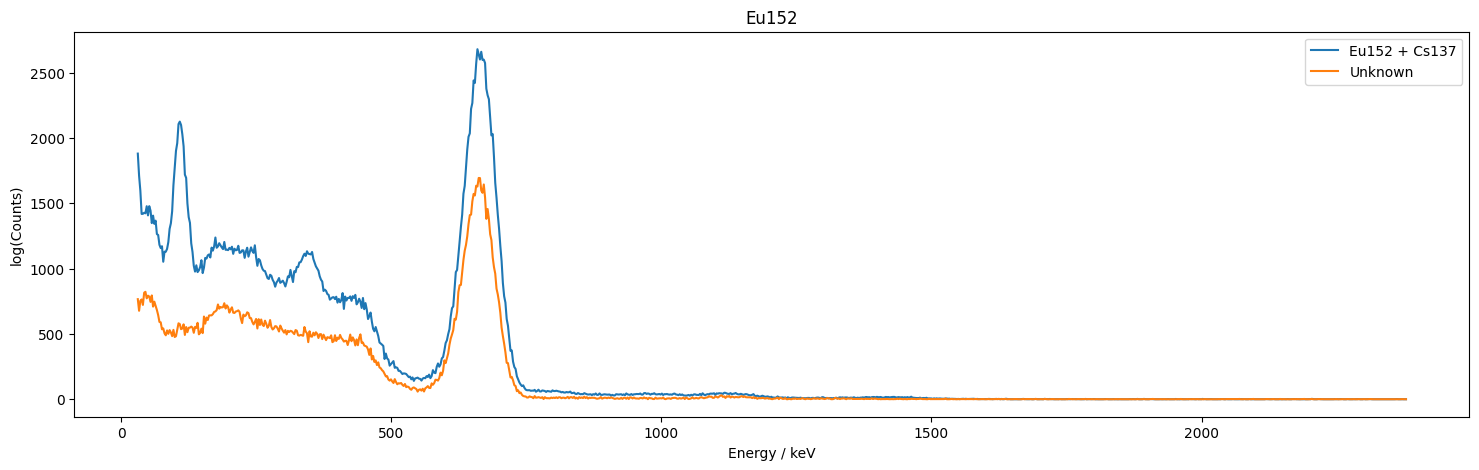

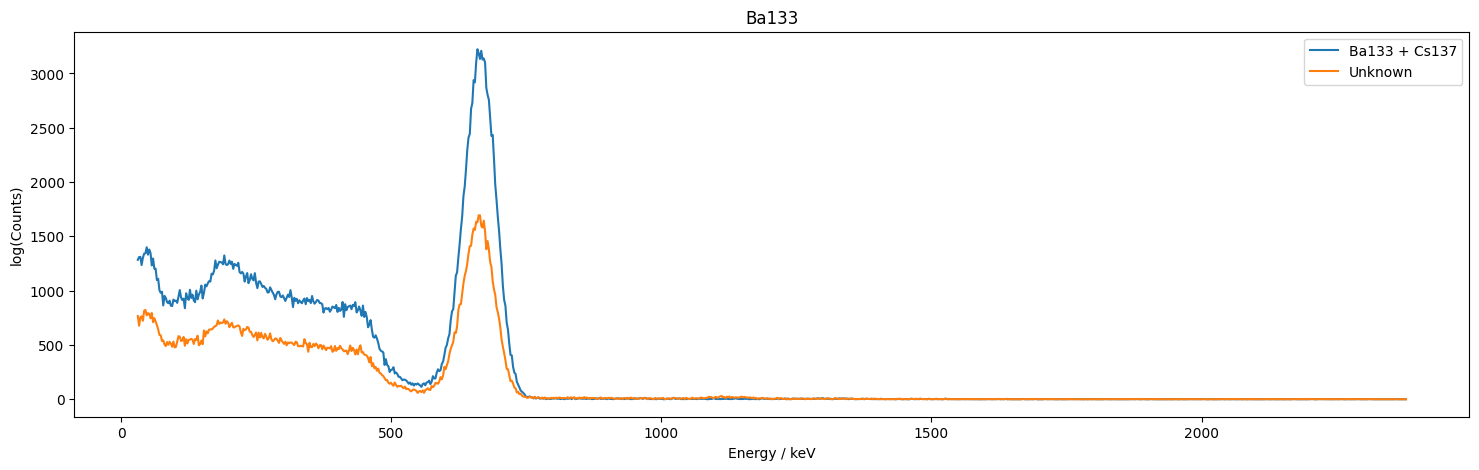

In [92]:
Cs137 = np.array(countss[1])
for i in range(len(elename)):
    Best_fit = np.array(countss[file_name.index(elename[i])])
    tot_pred_best = a[i] * Cs137 + (1 - a[i]) * Best_fit

    plt.figure(figsize=(18, 5))
    plt.plot(energy, tot_pred_best, label=f"{elename[i]} + Cs137")
    plt.plot(energy, countss[0], label="Unknown")
    plt.legend()
    plt.title(f"{elename[i]}")
    plt.ylabel("log(Counts)")
    plt.xlabel("Energy / keV")